# SalePrice Customer Study Notebook

## Objectives

*   Answer business requirement 1: 
    * The client is interested to understand the patterns from the customer base, so the client can learn the most relevant variables that are correlated to a churned customer.

## Inputs

* outputs/datasets/collection/HousePrediction.csv

## Outputs

* generate code that answers business requirement 1 and can be used to build the Streamlit App






---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [19]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/Project5_PredictiveAnalytics'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [20]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [21]:
current_dir = os.getcwd()
current_dir

'/workspaces'

---

# Load Data

In [22]:
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/HousePredictionPPS.csv")
    .drop(['WoodDeckSF', 'EnclosedPorch'], axis=1)
    .fillna(value=df['A'].mean(),inplace=True)
    )
df.head(3)

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/datasets/collection/HousePredictionPPS.csv'

# Data Exploration

We are interested to get more familiar with the dataset, check variable type and distribution, missing levels and what these variables mean in a business context

In [5]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# PPS and Correlation Study

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import ppscore as pps

def heatmap_corr(df,threshold, figsize=(20,12), font_annot = 8):
  if len(df.columns) > 1:
    mask = np.zeros_like(df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    mask[abs(df) < threshold] = True

    fig, axes = plt.subplots(figsize=figsize)
    sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                linewidth=0.5
                     )
    axes.set_yticklabels(df.columns, rotation = 0)
    plt.ylim(len(df.columns),0)
    plt.show()


def heatmap_pps(df,threshold, figsize=(20,12), font_annot = 8):
    if len(df.columns) > 1:

      mask = np.zeros_like(df, dtype=np.bool)
      mask[abs(df) < threshold] = True

      fig, ax = plt.subplots(figsize=figsize)
      ax = sns.heatmap(df, annot=True, xticklabels=True,yticklabels=True,
                       mask=mask,cmap='rocket_r', annot_kws={"size": font_annot},
                       linewidth=0.05,linecolor='grey')
      
      plt.ylim(len(df.columns),0)
      plt.show()



def CalculateCorrAndPPS(df):
  df_corr_spearman = df.corr(method="spearman")
  df_corr_pearson = df.corr(method="pearson")

  pps_matrix_raw = pps.matrix(df)
  pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

  pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
  print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
  print(pps_score_stats.round(3))

  return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix,CorrThreshold,PPS_Threshold,
                      figsize=(20,12), font_annot=8 ):

  print("\n")
  print("* Analyze how the target variable for your ML models are correlated with other variables (features and target)")
  print("* Analyze multi colinearity, that is, how the features are correlated among themselves")

  print("\n")
  print("*** Heatmap: Spearman Correlation ***")
  print("It evaluates monotonic relationship \n")
  heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

  print("\n")
  print("*** Heatmap: Pearson Correlation ***")
  print("It evaluates the linear relationship between two continuous variables \n")
  heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

  print("\n")
  print("*** Heatmap: Predictive power Score (PPS) ***")
  print(f"PPS detects linear or non-linear relationships between two columns.\n"
        f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
  heatmap_pps(df=pps_matrix,threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

In [13]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean   std  min  25%  50%    75%    max
ppscore  462.0  0.065  0.11  0.0  0.0  0.0  0.094  0.702


In [ ]:
from feature_engine.encoding import OneHotEncoder
encoder = OneHotEncoder(variables=df.columns[df.dtypes=='object'].to_list(), drop_last=False)
df_ohe = encoder.fit_transform(df)
print(df_ohe.shape)
df_ohe.head(3)

We use `.corr()` for `spearman` and `pearson` methods, and investigate the top 10 correlations
* We know this command returns a pandas series and the first item is the correlation between Churn and Churn, which happens to be 1, so we exclude that with `[1:]`
* We sort values considering the absolute value, by setting `key=abs`



* Analyze how the target variable for your ML models are correlated with other variables (features and target)
* Analyze multi colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



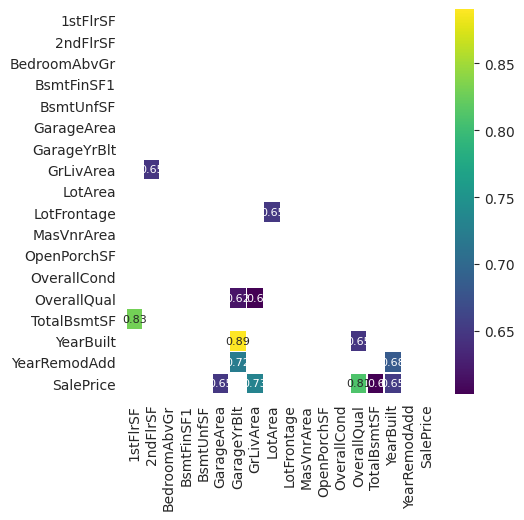



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



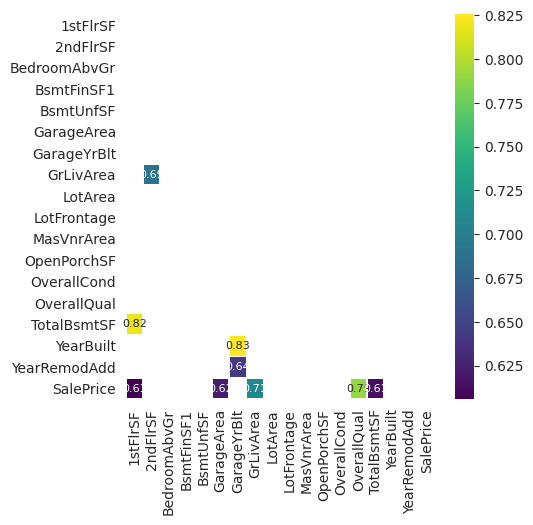



*** Heatmap: Predictive power Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



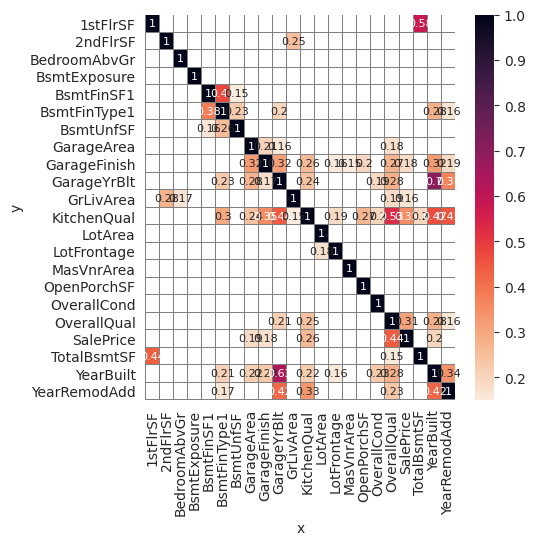

In [16]:
DisplayCorrAndPPS(df_corr_pearson=df_corr_pearson,
                  df_corr_spearman=df_corr_spearman, 
                  pps_matrix=pps_matrix,
                  CorrThreshold=0.6, PPS_Threshold=0.15,
                  figsize=(5,5), font_annot=8)

In [18]:
corr_spearman = df_ohe.corr(method='spearman')['SalePrice'].sort_values(key=abs, ascending=False)[1:].head(10)
corr_spearman

NameError: name 'df_ohe' is not defined

We do the same for `pearson`

In [ ]:
corr_pearson = df_ohe.corr(method='pearson')['SalePrice'].sort_values(key=abs, ascending=False)[1:].head(10)
corr_pearson

For both methods, we notice weak or moderate levels of correlation between Churn and a given variable. 
* Ideally, we pursue strong correlation levels. However, this is not always possible.

We will consider the top five correlation levels at `df_ohe` and will study the associated variables at `df`

In [ ]:
top_n = 5
set(corr_pearson[:top_n].index.to_list() + corr_spearman[:top_n].index.to_list())

Therefore we are studying at df the following variables. We will investigate if:
* A churned customer typically has a month-to-month contract.
* A churned customer typically has fiber optic.
* A churned customer typically doesn't have tech support.
* A churned customer doesn't have online security.
* A churned customer typically has low tenure levels.

In [ ]:
vars_to_study = ['Contract', 'InternetService', 'OnlineSecurity', 'TechSupport', 'tenure']
vars_to_study

# EDA on selected variables

In [ ]:
df_eda = df.filter(vars_to_study + ['Churn'])
df_eda.head(3)

## Variables Distribution by Churn

We plot the distribution (numerical and categorical) coloured by Churn

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')


def plot_categorical(df, col, target_var):

    plt.figure(figsize=(12, 5))
    sns.countplot(data=df, x=col, hue=target_var, order=df[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.title(f"{col}", fontsize=20, y=1.05)
    plt.show()


def plot_numerical(df, col, target_var):
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=col, hue=target_var, kde=True, element="step")
    plt.title(f"{col}", fontsize=20, y=1.05)
    plt.show()


target_var = 'Churn'
for col in vars_to_study:
    if df_eda[col].dtype == 'object':
        plot_categorical(df_eda, col, target_var)
        print("\n\n")
    else:
        plot_numerical(df_eda, col, target_var)
        print("\n\n")


---

## Parallel Plot

Create a separate DataFrame and transform `tenure` (numerical) into bins (categorical) for visualising at `parallel_categories()` plot


In [ ]:
from feature_engine.discretisation import ArbitraryDiscretiser
import numpy as np
tenure_map = [-np.Inf, 6, 12, 18, 24, np.Inf]
disc = ArbitraryDiscretiser(binning_dict={'tenure': tenure_map})
df_parallel = disc.fit_transform(df_eda)
df_parallel.head()

In [ ]:
disc.binner_dict_['tenure']

Create a map to replace the `tenure` variable with more informative levels.

In [ ]:
n_classes = len(tenure_map) - 1
classes_ranges = disc.binner_dict_['tenure'][1:-1]

labels_map = {}
for n in range(0, n_classes):
    if n == 0:
        labels_map[n] = f"<{classes_ranges[0]}"
    elif n == n_classes-1:
        labels_map[n] = f"+{classes_ranges[-1]}"
    else:
        labels_map[n] = f"{classes_ranges[n-1]} to {classes_ranges[n]}"

labels_map


Replace using `.replace()`

In [ ]:
df_parallel['tenure'] = df_parallel['tenure'].replace(labels_map)
df_parallel.head()

Creates multi-dimensional categorical data plot

In [ ]:
import plotly.express as px
fig = px.parallel_categories(df_parallel, color="Churn")
fig.show(renderer='colab')

---

# Conclusions and Next steps

The correlations and plots interpretation converge. 
* A churned customer typically has a month-to-month contract.
* A churned customer typically has fiber optic.
* A churned customer typically doesn't have tech support.
* A churned customer doesn't have online security.
* A churned customer typically has low tenure levels.

---

Well done! You generated code that answers business requirement 1 and can be used to build Streamlit App
* In this notebook, we are not pushing any file to the repo.
* Clear the cell's outputs before moving on!